<h1 align='center'>CF recommender system</h1> 

В данной работе я попробую построить коллаборативную рекомендательную систему <br>
на основе SVD разложения, а также с использованием ALS факторизации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import solve
from sklearn.utils.extmath import randomized_svd

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
books = pd.read_csv('Books.csv', dtype={'Year-Of-Publication': object})
ratings = pd.read_csv('ratings.csv')
users = pd.read_csv('Users.csv')

In [4]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [5]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [6]:
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


# Data preprocessing and visualization

In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [8]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [9]:
books.drop(['Image-URL-S','Image-URL-M','Image-URL-L'], axis=1, inplace=True)

In [10]:
books.dropna(inplace=True)

Можем заметить большое количество пропусков, в признаке возраста пользователей

In [11]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [12]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Уберем данные, где год выпуска равен '0' или вообще строке, также странно выглядят года вроде '2037', возможно это год планируемой публикации в их случае

In [13]:
books['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

In [14]:
books = books[~books['Year-Of-Publication'].isin(['0','DK Publishing Inc','Gallimard'])].astype({'Year-Of-Publication': int})

Попробуем разбить признак 'Location' на на три состовляющие, даже с учетом не всегда полных данных

In [15]:
users[['city','region','country']] = np.nan

for num, location in enumerate(users.Location):
    users.loc[num, 'city'] = location.split(',')[0].strip()
    try:
        users.loc[num, 'region'] = location.split(',')[1].strip()
    except IndexError:
        users.loc[num, 'region'] = 'n/a'
    try:
        users.loc[num, 'country'] = location.split(',')[2].strip()
    except IndexError:
        users.loc[num, 'country'] = 'n/a'    

Объединим наши датасеты в один общий

In [16]:
user_rating = ratings.merge(users, left_on = 'User-ID', right_on = 'User-ID')
full_data = user_rating.merge(books, left_on = 'ISBN', right_on = 'ISBN')

Десятка пользователей с наибольшим количеством прочитаных книг и их средний рейтинг

In [17]:
full_data.groupby('User-ID', as_index=False).agg({'ISBN':'count', 'Book-Rating':'mean'}).sort_values(by='ISBN', ascending=False) \
.rename({'ISBN': 'number_of_books', 'Book-Rating':'mean_books_rating'}, axis='columns')[:10]

,User-ID,number_of_books,mean_books_rating
3566,11676,10916,4.573379
64317,198711,6358,0.019346
50075,153662,5789,2.744170
32057,98391,5777,8.727194
11669,35859,5615,1.029386
69015,212898,4270,0.003513
90530,278418,3959,0.158373
24871,76352,3310,0.141994
36068,110973,2949,0.812818
76302,235105,2921,2.786717


Десяток самых популярных книг и их рейтинг

In [18]:
full_data.groupby(['Book-Title'], as_index=False).agg({'User-ID':'count','Book-Rating':'mean'}).sort_values(by='User-ID', ascending=False) \
.rename({'User-ID': 'number_of_users'}, axis='columns')[:10]

,Book-Title,number_of_users,Book-Rating
231432,Wild Animus,2502,1.019584
193177,The Lovely Bones: A Novel,1295,4.468726
180459,The Da Vinci Code,897,4.647715
5262,A Painted House,838,3.231504
196085,The Nanny Diaries: A Novel,828,3.530193
27561,Bridget Jones's Diary,815,3.527607
203330,The Secret Life of Bees,774,4.447028
52123,Divine Secrets of the Ya-Ya Sisterhood: A Novel,740,3.437838
201223,The Red Tent (Bestselling Backlist),723,4.334716
14266,Angels &amp; Demons,670,3.708955


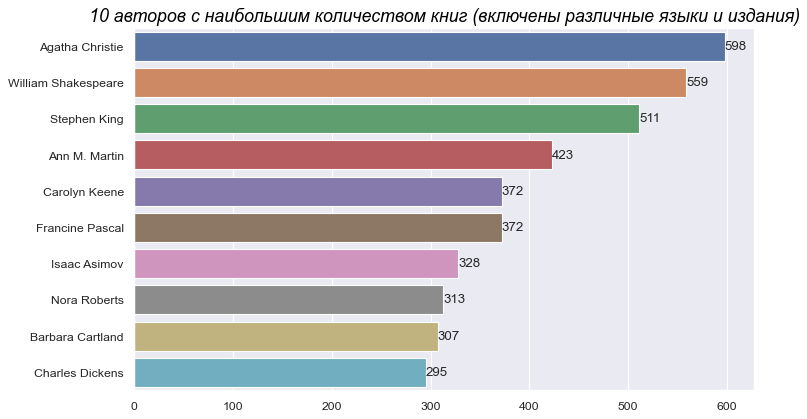

In [19]:
plt.figure(figsize=(10,6), dpi=80)
plt.title('10 авторов с наибольшим количеством книг (включены различные языки и издания)', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=books['Book-Author'].value_counts()[:10].index, x=books['Book-Author'].value_counts()[:10].values)
ax.bar_label(ax.containers[0])
plt.show()

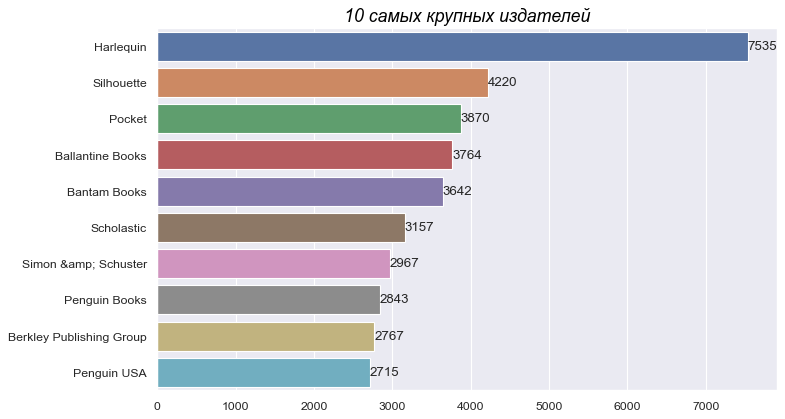

In [20]:
plt.figure(figsize=(10,6), dpi=80)
plt.title('10 самых крупных издателей', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=books['Publisher'].value_counts()[:10].index, x=books['Publisher'].value_counts()[:10].values)
ax.bar_label(ax.containers[0])
plt.show()

Реализуем алгоритм факторизации ALS, чтобы наша матрицаоценок пользователей не была такой разреженной

<!-- 1. Инициализация матриц пользователей и товаров случайными значениями:

Матрица пользователей: 

$$U = \begin{bmatrix}u_{1,1} & u_{1,2} & \dots & u_{1,k} \\ u_{2,1} & u_{2,2} & \dots & u_{2,k} \\ \vdots & \vdots & \ddots & \vdots \\ u_{n,1} & u_{n,2} & \dots & u_{n,k}\end{bmatrix}$$

Матрица товаров:

$$V = \begin{bmatrix}v_{1,1} & v_{1,2} & \dots & v_{1,m} \\ v_{2,1} & v_{2,2} & \dots & v_{2,m} \\ \vdots & \vdots & \ddots & \vdots \\ v_{k,1} & v_{k,2} & \dots & v_{k,m}\end{bmatrix}$$

где $n$ - количество пользователей, $m$ - количество товаров, $k$ - размерность скрытого пространства.

2. Оптимизация матрицы товаров при фиксированной матрице пользователей:

Для каждого столбца матрицы товаров:

$$V_j = (U^TU)^{-1}U^TR_j$$

где $R_j$ - вектор оценок пользователей для товара $j$.

3. Оптимизация матрицы пользователей при фиксированной матрице товаров:

Для каждой строки матрицы пользователей:

$$U_i = (VV^T)^{-1}VR_i^T$$

где $R_i$ - вектор оценок пользователя $i$ для всех товаров.

4. Вычисление предсказанных оценок пользователей для товаров:

$$\hat{R} = UV$$

5. Вычисление средней квадратичной ошибки:

$$MSE = \frac{1}{nm}\sum_{i=1}^{n}\sum_{j=1}^{m}(R_{ij} - \hat{R}_{ij})^2$$

6. Проверка на достижение требуемой точности:

Если $MSE < tolerance$, то завершаем оптимизацию. -->

In [21]:
def als(R, k, alpha=0.1, max_iter=200):

    N, M = R.shape
    P = np.random.rand(N, k)
    Q = np.random.rand(k, M)

    for _ in range(max_iter):
        for i in range(N):
            Q_t = Q[:, R[i, :] > 0]
            P[i, :] = np.linalg.solve(np.dot(Q_t, Q_t.T) + alpha * np.eye(k), np.dot(Q_t, R[i, R[i, :] > 0].T))

        for j in range(M):
            P_t = P[R[:, j] > 0, :]
            Q[:, j] = np.linalg.solve(np.dot(P_t.T, P_t) + alpha * np.eye(k), np.dot(P_t.T, R[R[:, j] > 0, j]))

    return P, Q

Чтобы упростить вычисления я буду использовать не всю матрицу, элементы матрицы выберу случайно

In [22]:
rand_index = np.random.choice(full_data.index,size=10000, replace=False)

In [23]:
crop_data = full_data[full_data.index.isin(rand_index)]

Создадим нашу матрицу оценок пользователей

In [24]:
pivot_crop_data = pd.pivot_table(crop_data, index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
pivot_crop_data.shape

(5231, 8621)

Применим нашу ALS факторизацию

In [25]:
P, Q = als(pivot_crop_data.values, 500)
(P @ Q).shape

(5231, 8621)

In [26]:
(P @ Q)[1:3, 0:10]

array([[0.        , 0.        , 0.        , 5.68827185, 0.        ,
        0.        , 0.        , 0.        , 5.39574549, 0.        ],
       [0.        , 0.        , 0.        , 4.70588891, 0.        ,
        0.        , 0.        , 0.        , 4.42092566, 0.        ]])

Так как после ALS факторизации матрица может принимать и отрицательные значения, мы округлим полученные значения <br>
и зададим границы наших оценок, которые были в пределах от 0 до 10

In [27]:
PQ = np.round(np.clip((P @ Q), 0, 10))

In [28]:
print(f'Количество нулей в исходной матрице = {(pivot_crop_data.values == 0).sum()} \n\
Количество нулей после факторизации = {(PQ == 0).sum()}')

Количество нулей в исходной матрице = 45092718 
Количество нулей после факторизации = 36584614


Матрица явно стала менее разреженной, но не настолько хорошо, как хотелось бы

In [29]:
U, s, Vt = randomized_svd(PQ, n_components=500, random_state=44)
predicted_ratings = np.round(np.clip(U.dot(np.diag(s)).dot(Vt), 0, 10))

In [30]:
predicted_ratings.shape

(5231, 8621)

In [31]:
books_dict = dict(zip(full_data['ISBN'].unique(), full_data['Book-Title'].unique()))

Возьмем пользователей, на которых будем тестировать рекомендации

In [32]:
new_users = pivot_crop_data.iloc[370:373]

In [33]:
new_users

ISBN,0002259877,0003252477,0004701674,0004709934,0006175465,000634156X,0006372570,0006374964,0006385621,0006472648,...,9681500954,968150108X,9684443102,9706516158,972211137X,9723704242,9728423160,981013004X,9812327975,9871138016
User-ID,,,,,,,,,,,,,,,,,,,,,
20918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Значит мы будем рекомендовать для каждого нашего пользователя топ 5 книг, которые ему стоит прочитать, <br>
книги будут отсортированы в порядке уверенности рекомендации 

In [34]:
recommendations = []
predictions = []
for i in range(new_users.values.shape[0]):
    user_ratings = new_users.values[i]
    predicted = U.dot(np.diag(s)).dot(Vt)
    predicted = np.delete(predicted[i], user_ratings.nonzero()[0])
    predictions.append(predicted)
    top_5_indices = predicted.argsort()[-5:][::-1]
    recommendations.append(top_5_indices)

columns = ['Recommended_Item_1', 'Recommended_Item_2', 'Recommended_Item_3', 'Recommended_Item_4', 'Recommended_Item_5']
recommendations_df = pd.DataFrame(columns=columns, index=new_users.index)

for i in range(new_users.shape[0]):
    row = [pivot_crop_data.columns[index] for index in recommendations[i]]
    recommendations_df.iloc[i] = row

In [35]:
recommendations_df

,Recommended_Item_1,Recommended_Item_2,Recommended_Item_3,Recommended_Item_4,Recommended_Item_5
User-ID,,,,,
20918,155874262X,0786868716,044022103X,0142001740,0439136350
20961,0786867647,1558670513,0439120489,0971879796,0385485662
20963,155874262X,0786868716,0439136350,0971880107,044022103X


Вот рекомендации для нашего 2-го пользователя в названиях книг, а не их книжный номер

In [36]:
recommendations_df.iloc[1].map(books_dict)

Recommended_Item_1                  Black Beauty (Illustrated Classics)
Recommended_Item_2                                      The Information
Recommended_Item_3    British Railways Past and Present: Wiltshire (...
Recommended_Item_4    From Global to Metanational: How Companies Win...
Recommended_Item_5                 Shaman Pass: A Nathan Active Mystery
Name: 20961, dtype: object

<b> Как можно улучшить систему рекомендаций?
    
1. Учитывать не только оценки пользователй, но и дополнительную информацию о пользователе и товаре, <br>
   такую как возраст, местоположение, жанр и т.д.

2. Расширить матрицу данных, чтобы увеличить точность рекомендаций.

3. Использовать методы группировки пользователей, чтобы учитывать схожие интересы и поведение пользователей.